#### Setting Up Kaggle Dataset Downloads

In [1]:
!pip install kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"washieuanan","key":"0e84e590fbab38e88b4eceae5dfa937a"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d landlord/handwriting-recognition

100% 1.26G/1.26G [00:17<00:00, 73.0MB/s]
100% 1.26G/1.26G [00:17<00:00, 75.7MB/s]


In [4]:
!ls

handwriting-recognition.zip  kaggle.json  sample_data


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('handwriting-recognition.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [6]:
import numpy as np 
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import random

import tensorflow as tf
import tensorflow.keras.backend as K 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout 
from tensorflow.keras.optimizers import Adam

#### Loading The Dataset

In [9]:
train = pd.read_csv('/content/files/written_name_train_v2.csv')
val = pd.read_csv('/content/files/written_name_validation_v2.csv')

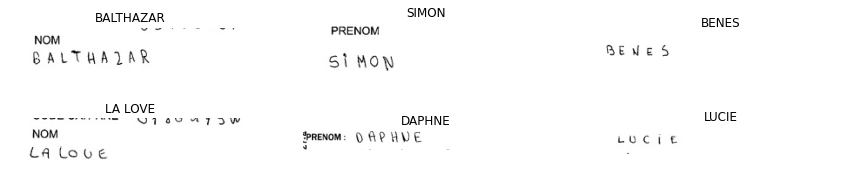

In [11]:
plt.figure(figsize = (15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/content/files/train_v2/train/' + train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize = 12)
    plt.axis('off')
    
    
plt.subplots_adjust(wspace= 0.2, hspace=-.8)

#### Cleaning The Data

In [12]:
#Checking for NaN Values
print("Training NaN's: ", train['IDENTITY'].isnull().sum())
print("Validation NaN's: ", val['IDENTITY'].isnull().sum())

Training NaN's:  565
Validation NaN's:  78


In [13]:
#Dropping the NaN values
train.dropna(axis = 0, inplace = True)
val.dropna(axis = 0, inplace = True)

In [14]:
#Removing the images classifed as 'UNREADABLE'
train = train[train['IDENTITY'] != 'UNREADABLE']
val = val[val['IDENTITY'] != 'UNREADABLE']

In [15]:
#Converting all labels into uppercase for uniformity 
train['IDENTITY'] = train['IDENTITY'].str.upper()
val['IDENTITY'] = val['IDENTITY'].str.upper()

In [16]:
#Resetting the index
train.reset_index(inplace = True, drop  = True)
val.reset_index(inplace = True, drop = True)

#### Preparing The Images

In [17]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [18]:
train_size = 30000
val_size = 3000

In [21]:
train_x = []

for i in range(train_size):
    img_dir = '/content/files/train_v2/train/' + train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255
    train_x.append(image)

In [22]:
valid_x = []

for i in range(val_size):
    img_dir = '/content/files/validation_v2/validation/'+val.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [23]:
train_x = np.array(train_x).reshape(-1, 256,64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

#### Preparing The Labels For CTC Loss

CTC loss, also known as connectionist temporal classification, is a transcription layer within a neural network. It is mainly used within text recognition problems. By using a CTC loss, we only have to specify the text that occurs in the image, thereby ignoring both the position and the width of the characters in the image. We are also no longer needed to perform further preprocessing on an image to get the character scores. If you would like to read more about CTC loss, refer to this [article](https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c).

If we are going to use the CTC loss for this text recognition problem, we must convert the labels to numbers, which will represent each character in the data. The alphabet that I will be providing will contain the following characters: <code>A-Z</code>, <code>-</code>, <code>'</code>, and spaces.


In [24]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [25]:
name = 'WASHIEU'
print(name, '\n',label_to_num(name))

WASHIEU 
 [22  0 18  7  8  4 20]


In [26]:
train_y = np.ones([train_size, max_str_len]) * -1 #contains the true labels that were converted to numbers
train_label_len = np.zeros([train_size, 1]) #contains the length of each true label 
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2) #contains the length of each predicted label. 
train_output = np.zeros([train_size]) #dummy output for ctc loss

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])

In [27]:
valid_y = np.ones([val_size, max_str_len]) * -1
valid_label_len = np.zeros([val_size, 1])
valid_input_len = np.ones([val_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([val_size])

for i in range(val_size):
    valid_label_len[i] = len(val.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(val.loc[i, 'IDENTITY'])]= label_to_num(val.loc[i, 'IDENTITY'])

In [28]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], 
      '\ntrain_input_len : ', train_input_len[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


#### Constructing The Model

In [29]:
input_data = Input(shape = (256, 64, 1), name = 'input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 64, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 64, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 256, 64, 32)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 128, 32, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 32, 64)       18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 32, 64)      

In [30]:
#CTC Loss Function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [31]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [32]:
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

with tf.device('/gpu:0'):
    model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=60, batch_size=128)

Epoch 1/60
235/235 [==============================] - 46s 196ms/step - loss: 24.3237 - val_loss: 20.6883
Epoch 2/60
235/235 [==============================] - 44s 189ms/step - loss: 20.1805 - val_loss: 20.1772
Epoch 3/60
235/235 [==============================] - 45s 191ms/step - loss: 19.8455 - val_loss: 19.7175
Epoch 4/60
235/235 [==============================] - 45s 192ms/step - loss: 19.4116 - val_loss: 19.1021
Epoch 5/60
235/235 [==============================] - 45s 192ms/step - loss: 18.5392 - val_loss: 18.0579
Epoch 6/60
235/235 [==============================] - 45s 193ms/step - loss: 17.3320 - val_loss: 16.4614
Epoch 7/60
235/235 [==============================] - 45s 192ms/step - loss: 15.6170 - val_loss: 14.4040
Epoch 8/60
235/235 [==============================] - 45s 193ms/step - loss: 13.5219 - val_loss: 13.0643
Epoch 9/60
235/235 [==============================] - 45s 192ms/step - loss: 11.3491 - val_loss: 12.2504
Epoch 10/60
235/235 [==============================] - 

#### Testing The Performance Of The Model

In [33]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(val_size):
    prediction.append(num_to_label(decoded[i]))

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [34]:
y_true = val.loc[0:val_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(val_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/val_size))

Correct characters predicted : 83.87%
Correct words predicted      : 70.53%


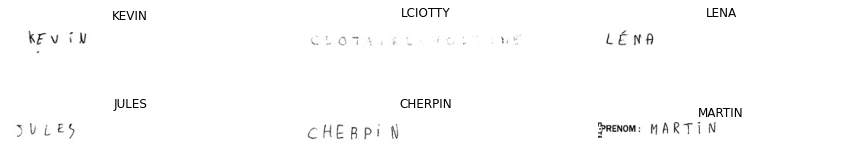

In [37]:
test = pd.read_csv('/content/files/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/content/files/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)